В этом блокноте я буду исследовать искажения, наблюдаемые в восстановленом изображении при различных искажениях в исходных сэмплах.

In [1]:
%matplotlib inline
from scipy import signal
from scipy.misc import face
from xray_inc_res import *

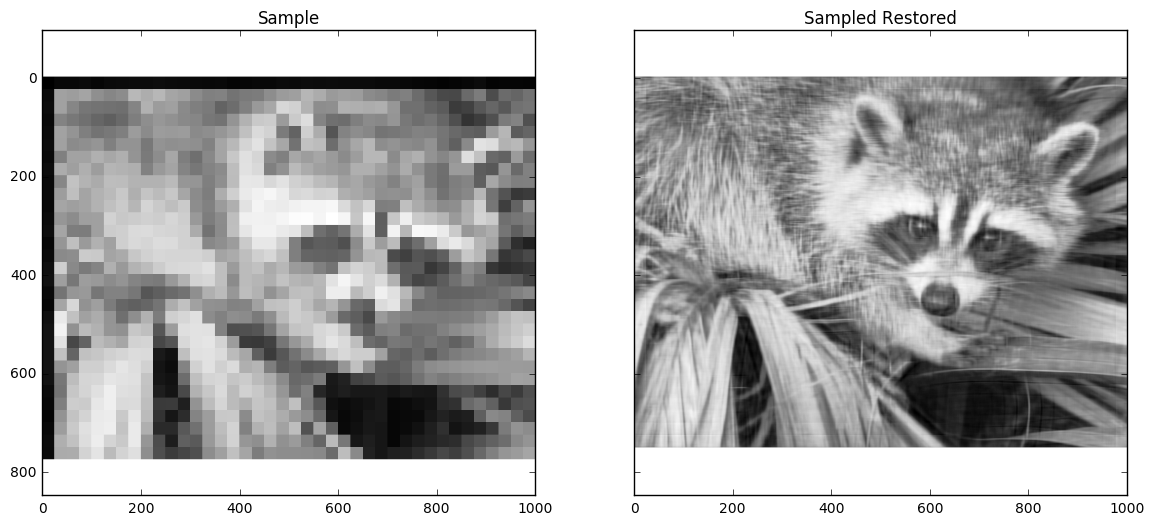

In [13]:
k = 25
psf = np.ones((k, k)) / k ** 2

src = face(gray=True); # imread("../images/peka.png", flatten=True)

src = cut_for_sampling(src, k)

samples = generate_samples(src, psf)

sigma = 0.2
for i in xrange(samples.shape[0]):
    for j in xrange(samples.shape[1]):
        samples[i,j] += np.random.normal(0, sigma, samples[i,j].shape)
        
sampled_conv = conv_from_samples(samples)
snr = sampled_conv[psf.shape[0]-1:-(psf.shape[0]-1),psf.shape[1]-1:-(psf.shape[1]-1)].mean() / sigma
sampled_rest = wiener_deconv2_adjsize(sampled_conv, psf, snr)
show_pics([upsample(samples[1,1], k), sampled_rest], ["Sample", "Sampled Restored"])

In [5]:
print np.min(samples[0,0]), np.max(samples[0,0])

0.193705662617 232.612983678


надо изменить яркость в случайное число раз

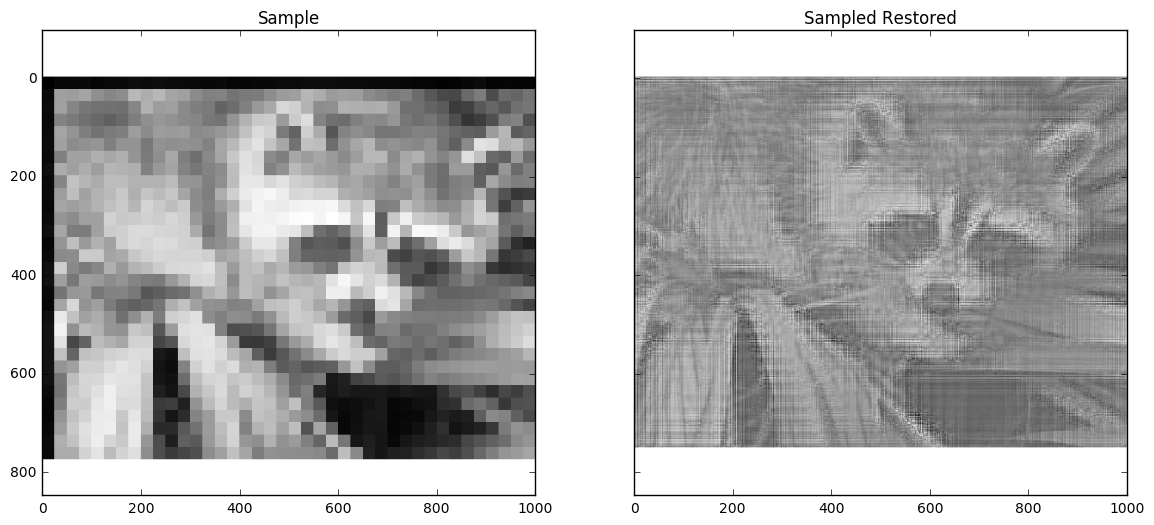

In [54]:
samples = generate_samples(src, psf)

for i in xrange(samples.shape[0]):
    for j in xrange(samples.shape[1]):
        samples[i,j] *= np.random.uniform(0.5, 2)
        
sigma = 0.2
for i in xrange(samples.shape[0]):
    for j in xrange(samples.shape[1]):
        samples[i,j] += np.random.normal(0, sigma, samples[i,j].shape)
        
sampled_conv = conv_from_samples(samples)
snr = sampled_conv[psf.shape[0]-1:-(psf.shape[0]-1),psf.shape[1]-1:-(psf.shape[1]-1)].mean() / sigma
sampled_rest = wiener_deconv2_adjsize(sampled_conv, psf, snr)
show_pics([upsample(samples[1,1], k), sampled_rest], ["Sample", "Sampled Restored"])

In [48]:
def average_brightness(path):
    img = imread(path, flatten=True)
    return img.mean()

In [42]:
def last_bright(search_dir, num=10):
    pic_names = [os.path.join(search_dir, f) for f in listdir(search_dir) if f.endswith(".png")] # add path to each file
    pic_names.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    for pic in pic_names[:num]:
        print pic, average_brightness(pic)

In [55]:
last_bright("c:/Users/Autex/Documents/Trident-IS_Data/0 T/0 G/0 M/0 K/1/", 10)

c:/Users/Autex/Documents/Trident-IS_Data/0 T/0 G/0 M/0 K/1/TridentI2B17.png 38.2162
c:/Users/Autex/Documents/Trident-IS_Data/0 T/0 G/0 M/0 K/1/TridentI4436.png 64.9122
c:/Users/Autex/Documents/Trident-IS_Data/0 T/0 G/0 M/0 K/1/TridentI2A1.png 32.2576
c:/Users/Autex/Documents/Trident-IS_Data/0 T/0 G/0 M/0 K/1/TridentI57A4.png 57.8802
c:/Users/Autex/Documents/Trident-IS_Data/0 T/0 G/0 M/0 K/1/TridentI7E9C.png 32.1574
c:/Users/Autex/Documents/Trident-IS_Data/0 T/0 G/0 M/0 K/1/TridentI3C57.png 60.4633
c:/Users/Autex/Documents/Trident-IS_Data/0 T/0 G/0 M/0 K/1/TridentI4B83.png 112.242
c:/Users/Autex/Documents/Trident-IS_Data/0 T/0 G/0 M/0 K/1/TridentI5AE0.png 154.157
c:/Users/Autex/Documents/Trident-IS_Data/0 T/0 G/0 M/0 K/1/TridentI582E.png 72.435
c:/Users/Autex/Documents/Trident-IS_Data/0 T/0 G/0 M/0 K/1/TridentI1C7B.png 77.611


In [139]:
def additive_noise(samples, rel_sigma):
    noisy_samples = samples[:,:]
    for i in xrange(samples.shape[0]):
        for j in xrange(samples.shape[1]):
#             print rel_sigma*samples[i,j].mean()
            m = samples[i,j].mean()
            if m != 0:
                noisy_samples[i,j] = samples[i,j] + np.random.normal(0, rel_sigma*m, samples[i,j].shape)
    return noisy_samples

In [140]:
def multiplicative_noise(samples, mult):
    noisy_samples = samples[:,:]
    for i in xrange(samples.shape[0]):
        for j in xrange(samples.shape[1]):
            noisy_samples[i,j] = samples[i,j] * np.random.uniform(mult[0], mult[1])
    return noisy_samples

In [102]:
samples = generate_samples(src, psf)
# samples = generate_samples_rand_move(src, psf)

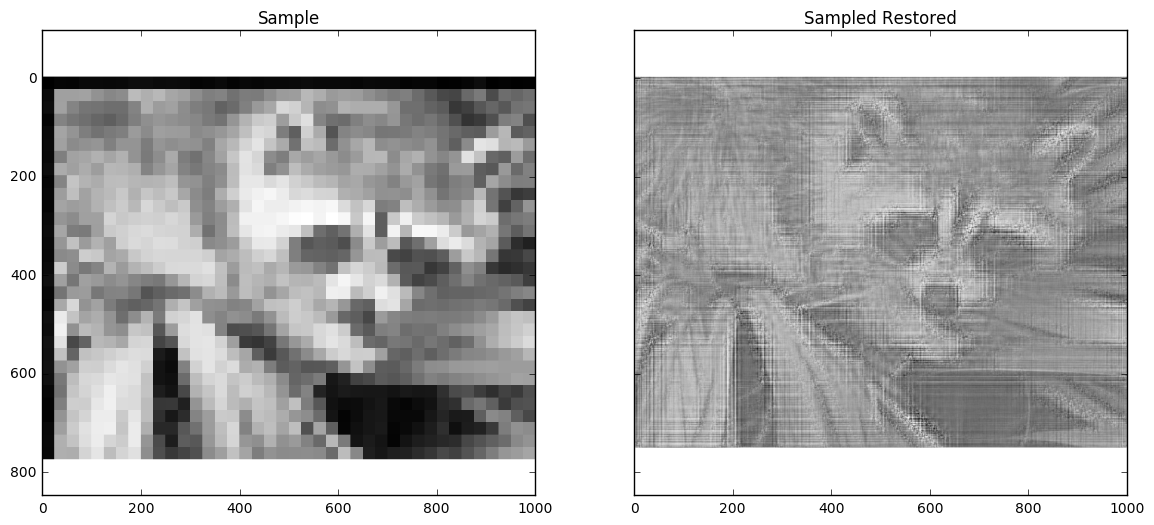

In [103]:
samples = additive_noise(samples, 0.01)
samples = multiplicative_noise(samples, (0.5, 2))
# for i in xrange(samples.shape[0]):
#     for j in xrange(samples.shape[1]):
#         samples[i,j] *= np.random.uniform(0.5, 2)
        
sampled_conv = conv_from_samples(samples)
snr = sampled_conv[psf.shape[0]-1:-(psf.shape[0]-1),psf.shape[1]-1:-(psf.shape[1]-1)].mean() / sigma
sampled_rest = wiener_deconv2_adjsize(sampled_conv, psf, snr)
show_pics([upsample(samples[1,1], k), sampled_rest], ["Sample", "Sampled Restored"])

In [16]:
r = np.array([[0, 1, 2, 3],
              [4, 5, 6, 7],
              [8, 9, 10, 11],
              [12, 13, 14, 15]])
k = 3
p = np.ones((k, k)) / k**2
print r
print p
acx = 0; acy = 0;
alx = 0.5; aly = 0.5

m = 0; n = 0;

#  formula does two steps simultaneously:
#  1. transform original matrix according to borders which don't batch pixels' borders
#  2. apply psf to new matrix
s = 0;
for i in xrange(k):
    for j in xrange(k):
        s += (r[acx + m*k + i, acy + n*k + j] * (1 - alx) * (1 - aly) + \
              r[acx + m*k + i + 1, acy + n*k + j] * alx * (1 - aly) + \
              r[acx + m*k + i, acy + n*k + j + 1] * (1 - alx) * (1 - aly) + \
              r[acx + m*k + i + 1, acy + n*k + j + 1] * alx * aly) * p[i, j]

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[ 0.11111111  0.11111111  0.11111111]
 [ 0.11111111  0.11111111  0.11111111]
 [ 0.11111111  0.11111111  0.11111111]]
0.277777777778
0.666666666667
1.16666666667
1.88888888889
2.72222222222
3.66666666667
4.83333333333
6.11111111111
7.5
7.5


In [96]:
def generate_samples(img, psf):
    k = psf.shape[0]; # assume psf as square template
    
    # pad image with zeros
    padded = np.pad(img, [(k-1, k-1), (k-1, k-1)], "constant", constant_values=0)
    
    sample_rows, sample_cols = padded.shape[0] / k, padded.shape[1] / k
    samples = np.empty((k, k, sample_rows, sample_cols))  
    
    # anchor_y, anchor_x - coordinates in img, from where we start to attach the template (upper left corner)
    for anchor_y in xrange(k):
        for anchor_x in xrange(k):
            tmp = np.zeros((sample_rows, sample_cols))
            
            # y, x - coordinates where the template (upper left corner) is attached
            for y in xrange(anchor_y, padded.shape[0] - (k-1), k):
                for x in xrange(anchor_x, padded.shape[1] - (k-1), k):
                    i = (y - anchor_y) / k
                    j = (x - anchor_x) / k
                    tmp[i, j] = np.sum(padded[y:y+k, x:x+k] * psf)
            samples[anchor_y, anchor_x] = tmp
    return samples

In [3]:
def step(cur_coord, step_size, max_error):
    res_coord = cur_coord
    sign = 1 if step_size > 0 else -1
    for i in xrange(abs(step_size)):
        res_coord += sign + np.random.uniform(-max_error, max_error)
    return res_coord
        
print step(5, 3, 0.2)


7.56690383818


In [144]:
def generate_samples_rand_move(img, psf, max_move_error):
    k = psf.shape[0]; # assume psf as square template
    
    # pad image with zeros
    padded = np.pad(img, [(k-1, k-1), (k-1, k-1)], "constant", constant_values=0)
    
    sample_rows, sample_cols = padded.shape[0] / k, padded.shape[1] / k
    samples = np.empty((k, k, sample_rows, sample_cols))  
    
    padded = np.pad(padded, [(0, int((k-1)*max_move_error+1)), (0, int((k-1)*max_move_error+1))], 
                    "constant", constant_values=0)
    
    # anchor_y, anchor_x - coordinates in img, from where we start to attach the template (upper left corner)
    real_anchor_y = 0
    for exp_anchor_y in xrange(k):  
        real_anchor_x = 0
        for exp_anchor_x in xrange(k):
            tmp = np.zeros((sample_rows, sample_cols))
            Y = np.arange(real_anchor_y, padded.shape[0] - k, k)[:sample_rows]
            X = np.arange(real_anchor_x, padded.shape[1] - k, k)[:sample_cols]
#             print real_anchor_x, padded.shape[1] - k
#             print X
            
            for i in xrange(len(Y)):
                y = Y[i]
                luy = int(y) # left upper y
                sy = y - luy # y shift within pixel
                for j in xrange(len(X)):
                    tmp[i, j] = 0; 
                    x = X[j]
                    lux = int(x);
                    sx = x - lux;
                    
                    for n in xrange(k):
                        for m in xrange(k):
                            tmp[i, j] += (padded[luy + n, lux + m] * (1 - sx) * (1 - sy) + \
                                          padded[luy + n, lux + m + 1] * sx * (1 - sy) + \
                                          padded[luy + n + 1, lux + m] * (1 - sx) * sy + \
                                          padded[luy + n + 1, lux + m + 1] * sx * sy) * psf[n, m]
            samples[exp_anchor_y, exp_anchor_x] = tmp
            
            real_anchor_x = step(real_anchor_x, 1, max_move_error)
        real_anchor_y = step(real_anchor_y, 1, max_move_error)
    return samples

In [161]:
src = imread("../images/joker.png", flatten=True)
k = 3
psf = np.ones((k, k)) / k ** 2
src = cut_for_sampling(src, k)
samples = generate_samples_rand_move(src, psf, 0.2)
# samples = generate_samples(src, psf)
rel_sigma = 0.3
sigma = rel_sigma * samples.mean()
samples = additive_noise(samples, rel_sigma)
# samples = multiplicative_noise(samples, (0.5, 4))

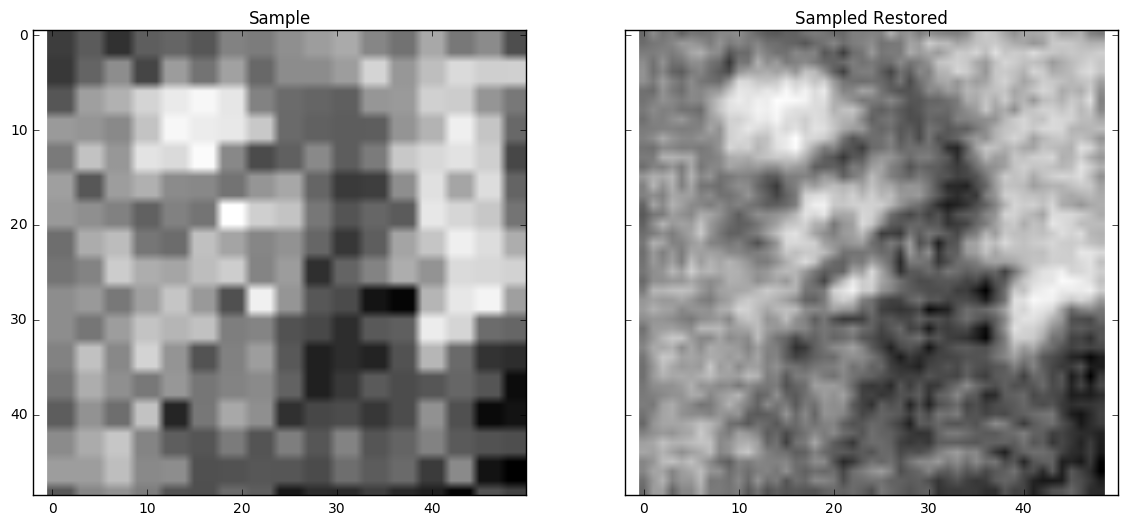

In [162]:
sampled_conv = conv_from_samples(samples)
snr = sampled_conv[psf.shape[0]-1:-(psf.shape[0]-1),psf.shape[1]-1:-(psf.shape[1]-1)].mean() / sigma
sampled_rest = wiener_deconv2_adjsize(sampled_conv, psf, snr)
show_pics([upsample(samples[1,1], k), sampled_rest], ["Sample", "Sampled Restored"])